In [38]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# Sklearn regressors
from sklearn.ensemble import RandomForestRegressor

# Sklearn forecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg

from sklearn.linear_model import LinearRegression

In [2]:
RANDOM_SEED = 671993

In [18]:
def get_validation_year_week(year: int):
    return [f'{year}-{week}' for week in range(31,39)]

def train_test_split_folds(df):
    folds = []
    for year in np.sort(df.year.unique()):
        train_upper_limit = f'{year}-31'
        validation_weeks = get_validation_year_week(year)

        train_condition = (~df.year_week.isin(validation_weeks)) & (df.year_week < train_upper_limit)
        val_condition = (df.year_week.isin(validation_weeks))

        train_split = df[train_condition]
        val_split = df[val_condition]

        cols = ['DateAsFloat', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
        folds.append({
            'train': train_split[cols],
            'validation':val_split[cols]
        })

    return folds

def apply_date_format(df):
    df['Date'] = pd.to_datetime(df['Date'])
    date_aux = df['Date']

    df['year'] = date_aux.dt.year
    df['month'] = date_aux.dt.month
    df['week'] = date_aux.dt.isocalendar().week
    df['year_month'] = date_aux.dt.strftime('%Y-%m')
    df['year_week'] = date_aux.dt.strftime('%Y-%V')

    return df

In [19]:
df = apply_date_format(
    df=pd.read_csv('../rossmann-store-sales/train.csv')
)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]
df.dtypes

/Users/francotestori/dsuba/series_temporales/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
year                      int64
month                     int64
week                     UInt32
year_month               object
year_week                object
dtype: object

In [22]:
analysis_df = df[df.Store == 1]
# reverse to the order: from 2013 to 2015
analysis_df = analysis_df.sort_index(ascending = False)
analysis_df['DateAsFloat'] = pd.to_numeric(analysis_df.Date)
analysis_df.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
year                      int64
month                     int64
week                     UInt32
year_month               object
year_week                object
DateAsFloat               int64
dtype: object

In [23]:
time_splitted_folds = train_test_split_folds(df=analysis_df)
len(time_splitted_folds)

3

In [35]:
def rmspe(y_pred, y_true):
    """
    Compute Root Mean Square Percentage Error between two arrays.
    :param y_pred:
    :param y_true:
    :return:
    """
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))
    return loss

results = []
for fold in time_splitted_folds:
    train = fold["train"]
    val = fold["validation"]

    X_train = train.drop(['Sales', 'Customers'], axis = 1)
    y_train = train['Sales']

    X_val = train.drop(['Sales', 'Customers'], axis = 1)
    y_val = train.Sales

    clf = LinearRegression()

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)

    results.append({
        'rmpse': rmspe(
            y_pred=y_pred,
            y_true=y_val
        ),
        'y_pred': y_pred,
        'y_true': y_val
    })

In [29]:
pd.DataFrame(results)

,rmpse,y_pred,y_true
0,0.196674,"[5373.1383417233155, 5308.068501642963, 5242.9...",1014980 5530 1013865 4327 1012750 448...
1,0.208927,"[5059.318776751326, 5058.452114543074, 5057.58...",1014980 5530 1013865 4327 1012750 448...
2,0.212541,"[4969.645189355635, 4969.18686604408, 4968.728...",1014980 5530 1013865 4327 1012750 448...


In [36]:
def regression_results(y_pred, y_true):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('RESULTS')
    print('----------------------------------------------------------')
    print(f'explained_variance: {round(explained_variance,4)}')
    print(f'mean_squared_log_error: {round(mean_squared_log_error,4)}')
    print(f'r2: {round(r2,4)}')
    print(f'MAE: {round(mean_absolute_error,4)}')
    print(f'MSE: {round(mse,4)}')
    print(f'RMSE: {round(np.sqrt(mse),4)}')
    print(f'RMSPE: {round(rmspe(y_pred, y_true),4)}')
    print(f'median_absolute_error: {round(median_absolute_error,4)}')
    print('\n')

In [37]:
for result in results:
    y_pred = result['y_pred']
    y_true = result['y_true']
    regression_results(
        y_pred=y_pred,
        y_true=y_true
    )

RESULTS
----------------------------------------------------------
explained_variance: 0.0663
mean_squared_log_error: 0.0344
r2: 0.0663
MAE: 730.8062
MSE: 850214.9532
RMSE: 922.071
RMSPE: 0.1967
median_absolute_error: 582.278


RESULTS
----------------------------------------------------------
explained_variance: 0.0217
mean_squared_log_error: 0.0397
r2: 0.0217
MAE: 775.7378
MSE: 956381.5464
RMSE: 977.9476
RMSPE: 0.2089
median_absolute_error: 669.7875


RESULTS
----------------------------------------------------------
explained_variance: 0.0149
mean_squared_log_error: 0.0417
r2: 0.0149
MAE: 784.339
MSE: 1011494.9788
RMSE: 1005.7311
RMSPE: 0.2125
median_absolute_error: 679.3685




In [67]:
def plot_sales_time_series(df_to_plot):

    df_aux = df_to_plot.groupby('year_week').sum().reset_index()

    plt.plot(df_aux.year_week, df_aux.y_true, label='y_true')
    plt.plot(df_aux.year_week, df_aux.y_pred, label='y_pred')

    plt.title(f'Results for fold')
    plt.legend()
    plt.show()

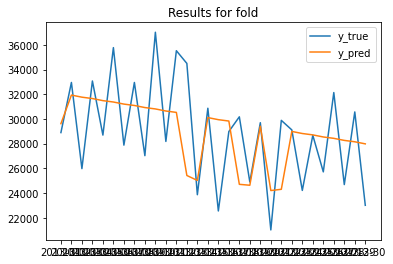

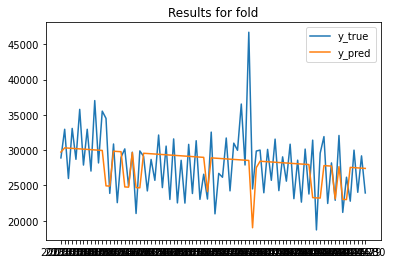

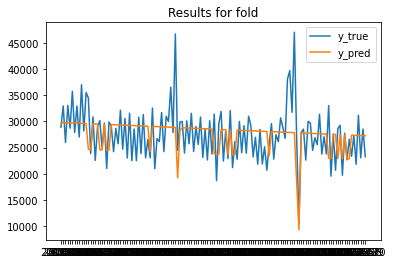

In [68]:
complete_results = []
for fold, result in zip(time_splitted_folds, results):
    data = fold['train']

    data['y_true'] = result['y_true']
    data['y_pred'] = result['y_pred']

    data['Date'] = pd.to_datetime(data['DateAsFloat'])
    data['year_month'] = data['Date'].dt.strftime('%Y-%m')
    data['year_week'] = data['Date'].dt.strftime('%Y-%V')

    complete_results.append(data)

for data in complete_results:
    plot_sales_time_series(df_to_plot=data)